<a href="https://colab.research.google.com/github/danielleitesoares/Work_Sentimental_Analyzer_Of_Restaurant_Issue/blob/main/Analise_dos_Sentimentos_Restaurantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Analise de Sentimentos Restaurantes**
> Equipe: Leonardo Rocha, Paulo Correa e Daniel Soares
> Turma 02





### 0.Importação das Bibliotecas Utilizadas 




In [33]:
# coding = utf-8  
#Bibliotecas Básicas 
import pandas as pd
import numpy as np
import json
import nltk
import time  # avaliar
#Bibliotecas de Gráficos e Relatórios 
import seaborn as sns
import matplotlib
import pandas_profiling as ppf
from pandas_profiling import ProfileReport

#Bibliotecas de Análise de Sentimentos
import textblob


### 1.Tratamento do dataset-v2.dat

##### 1.1. Abrindo o Dataset 

In [34]:
nltk.download('punkt')
! git clone https://github.com/paulordie/sentimental_ds
%cd sentimental_ds/

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Cloning into 'sentimental_ds'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 98 (delta 0), reused 2 (delta 0), pack-reused 95
Unpacking objects: 100% (98/98), done.
Checking out files: 100% (11/11), done.
/content/sentimental_ds/sentimental_ds


##### 1.2 Transformação do DAT no JSON

In [35]:
dados = open('dataset-v2.dat')
a = dados.readlines()# Criar uma lista com todos as linhas em strings 
v = [] # vetor para salvar cada linha em json  
#Rodar um for para correr por cada item de "a" que está as linhas 
for c in range(0,len(a)):
  parsed_c = json.loads(a[c])#aqui estamos transformando as strings de "a" em arquivos json
  data = pd.json_normalize(parsed_c)#aqui pegamos os arquivos json e normaliamos eles 
  v.append(data)#jogamos os arquivos em 'V'
  #aqui vamos concatenar cada linha que está em 'V' para um unico dataset df 
df = pd.concat(objs=v,axis=0)#concatenando 

##### 1.3 Salvando em outros formatos

In [ ]:
#Converterndo e Salvando em CSV
df.to_csv('/content/drive/My Drive/dataset123.csv')#salvando o arquivo em csv  \\\\\\\\\\\\\\\\\\\\\verificar
#Convertendo e salvar em excel 
df.to_excel('/content/drive/My Drive/dataset.xlsx')

##### 1.4 Exibindo o Head do dataset

In [40]:
df = df.rename(columns={'itemReviewed.name':'Name','itemReviewed.address.streetAddress':'StressAddress','itemReviewed.address.addressLocality':'AddressLocality','itemReviewed.address.addressRegion':'AddressRegion','itemReviewed.address.postalCode':'PostalCode','itemReviewed.address.country':'Country','itemReviewed.website':'Website','itemReviewed.email':'Email','itemReviewed.phoneNumber':'PhoneNumber','itemReviewed.averageRating':'AverageRating'})
df = df.reset_index(drop=True)
df.head(10)


,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,Name,StressAddress,AddressLocality,AddressRegion,PostalCode,Country,Website,Email,PhoneNumber,AverageRating
0,Jantar,692856288,2344932,larinhavercosa222,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,"São Carlos, SP",26/07/2019,07/2019,5,Imperador dos Camarões,Avenida Doutor Antônio Gouveia,,Alagoas,57030-170,Brasil,http://www.imperadordoscamaroes.com.br,contato@imperadordoscamaroes.com.br,+55 82 3231-4134,4.5
1,Uma boa experiência.,229208487,3720906,Pano P,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,"Manaus, AM",16/09/2014,None,4,Guacamole Natal,Avenida Praia de Ponta Negra 9068 Ponta Negra,,Rio Grande do Norte,59092-100,Brasil,http://www.facebook.com/GuacamoleNatal,guacamolenatal@gmail.com,+55 84 3219-3646,4.5
2,Otimo self service,679002332,2248105,Magma100,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,"Goiânia, GO",04/06/2019,07/2018,4,Chica Pitanga,Rua Petrolina 19,Recife,Pernambuco,51021-250,Brasil,http://www.chicapitanga.com.br,chicapitanga@chicapitanga.com.br,+55 81 3334-8260,4.5
3,O sorvete mais tradicional do estado,355671519,8168302,Yurie M,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,"Aracaju, SE",15/03/2016,01/2016,5,Sorvetes Vi Sabor,Avenida Francisco Porto 59 Grageru,Aracaju,Sergipe,,Brasil,None,None,None,4.0
4,Melhor hamburger!,268741921,5395141,Debora_C85,O melhor hamburger que já comi! Excelente aten...,pt,False,"Rio de Janeiro, RJ",28/04/2015,04/2015,5,Z Deli Sandwich Shop,Rua Haddock Lobo 1386 Jardins,São Paulo,Estado de São Paulo,01414-002,Brasil,http://www.facebook.com/zdelisandwichshop/,None,551130830021,4.5
5,Um achado maravilhoso!,482361860,12209902,Monique C,"O restaurante é novo, super acolhedor e charmo...",pt,False,None,07/05/2017,05/2017,5,Trattoria della Gloria,Rua do Russel 450,Rio de Janeiro,Estado do Rio de Janeiro,22210-010,Brasil,https://www.facebook.com/trattoriadellagloria....,info@trattoriadellagloria.com.br,+55 21 3435-6789,4.5
6,Saboroso,431356071,5565144,ChrisWings,"Fomos num sábado, ambiente elegante, equipe ge...",pt,True,"Brasília, DF",24/10/2016,10/2016,4,Tomyam,"José Maria Lisboa, 1065 Jardim Paulista",São Paulo,Estado de São Paulo,01423-003,Brasil,http://www.tomyam.com.br/,tomyamsp@tomyamsp.com.br,+55 11 4329-1002,4.0
7,Bom trabalho,361607766,2408078,lucianasoares18,Comida ótima e com bom atediamento e com muita...,pt,False,"Vila Velha, ES",04/04/2016,04/2016,4,Ilha do Caranguejo - Vitória,"Rua Alcino Pereira Netto, 570 - Jardim Camburi...",Vitória,Espírito Santo,29090-540,Brasil,http://www.ilhadocaranguejo.com.br,ilha@ilha.es,+55 27 3395-0244,4.5
8,Maravilhoso!,622424870,9738862,Andrezza O,"Ambiente agradável, preço totalmente acessível...",pt,True,"Teresina, PI",05/10/2018,10/2018,5,Vertigo Restaurante,"R. Aviador Irapua Rocha, 2370 Bairro Ininga",Teresina,Piauí,64049-740,Brasil,None,None,08632334338,4.0
9,Mais tradicional de BH,400149803,3514720,Leonardo R,A pizzaria é a mais tradicional de Belo Horizo...,pt,False,"Belo Horizonte, MG",01/08/2016,07/2016,5,Pizzarella,"Av. Olegário Maciel, 2.280 - Lourdes",Belo Horizonte,Minas Gerais,,Brasil,http://www.pizzarellasaobento.com.br/home/defa...,None,(31) 3292-3000,4.0


,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,Name,StressAddress,AddressLocality,AddressRegion,PostalCode,Country,Website,Email,PhoneNumber,AverageRating
0,Jantar,692856288,2344932,larinhavercosa222,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,"São Carlos, SP",26/07/2019,07/2019,5,Imperador dos Camarões,Avenida Doutor Antônio Gouveia,,Alagoas,57030-170,Brasil,http://www.imperadordoscamaroes.com.br,contato@imperadordoscamaroes.com.br,+55 82 3231-4134,4.5
1,Uma boa experiência.,229208487,3720906,Pano P,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,"Manaus, AM",16/09/2014,None,4,Guacamole Natal,Avenida Praia de Ponta Negra 9068 Ponta Negra,,Rio Grande do Norte,59092-100,Brasil,http://www.facebook.com/GuacamoleNatal,guacamolenatal@gmail.com,+55 84 3219-3646,4.5
2,Otimo self service,679002332,2248105,Magma100,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,"Goiânia, GO",04/06/2019,07/2018,4,Chica Pitanga,Rua Petrolina 19,Recife,Pernambuco,51021-250,Brasil,http://www.chicapitanga.com.br,chicapitanga@chicapitanga.com.br,+55 81 3334-8260,4.5
3,O sorvete mais tradicional do estado,355671519,8168302,Yurie M,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,"Aracaju, SE",15/03/2016,01/2016,5,Sorvetes Vi Sabor,Avenida Francisco Porto 59 Grageru,Aracaju,Sergipe,,Brasil,None,None,None,4.0
4,Melhor hamburger!,268741921,5395141,Debora_C85,O melhor hamburger que já comi! Excelente aten...,pt,False,"Rio de Janeiro, RJ",28/04/2015,04/2015,5,Z Deli Sandwich Shop,Rua Haddock Lobo 1386 Jardins,São Paulo,Estado de São Paulo,01414-002,Brasil,http://www.facebook.com/zdelisandwichshop/,None,551130830021,4.5
5,Um achado maravilhoso!,482361860,12209902,Monique C,"O restaurante é novo, super acolhedor e charmo...",pt,False,None,07/05/2017,05/2017,5,Trattoria della Gloria,Rua do Russel 450,Rio de Janeiro,Estado do Rio de Janeiro,22210-010,Brasil,https://www.facebook.com/trattoriadellagloria....,info@trattoriadellagloria.com.br,+55 21 3435-6789,4.5
6,Saboroso,431356071,5565144,ChrisWings,"Fomos num sábado, ambiente elegante, equipe ge...",pt,True,"Brasília, DF",24/10/2016,10/2016,4,Tomyam,"José Maria Lisboa, 1065 Jardim Paulista",São Paulo,Estado de São Paulo,01423-003,Brasil,http://www.tomyam.com.br/,tomyamsp@tomyamsp.com.br,+55 11 4329-1002,4.0
7,Bom trabalho,361607766,2408078,lucianasoares18,Comida ótima e com bom atediamento e com muita...,pt,False,"Vila Velha, ES",04/04/2016,04/2016,4,Ilha do Caranguejo - Vitória,"Rua Alcino Pereira Netto, 570 - Jardim Camburi...",Vitória,Espírito Santo,29090-540,Brasil,http://www.ilhadocaranguejo.com.br,ilha@ilha.es,+55 27 3395-0244,4.5
8,Maravilhoso!,622424870,9738862,Andrezza O,"Ambiente agradável, preço totalmente acessível...",pt,True,"Teresina, PI",05/10/2018,10/2018,5,Vertigo Restaurante,"R. Aviador Irapua Rocha, 2370 Bairro Ininga",Teresina,Piauí,64049-740,Brasil,None,None,08632334338,4.0
9,Mais tradicional de BH,400149803,3514720,Leonardo R,A pizzaria é a mais tradicional de Belo Horizo...,pt,False,"Belo Horizonte, MG",01/08/2016,07/2016,5,Pizzarella,"Av. Olegário Maciel, 2.280 - Lourdes",Belo Horizonte,Minas Gerais,,Brasil,http://www.pizzarellasaobento.com.br/home/defa...,None,(31) 3292-3000,4.0


Varredura do JSON por linha

In [ ]:
listOfDataBase = list()
listOfData = []
 
def findKeys(dataBase):
    for register in dataBase:
        try:
            cols = register.split('\n')
            listOfDataBase.append(cols[0])
        except UnicodeDecodeError:
            print("Error on uncode decode findkeys")
    print("Find Keys: ",listOfDataBase)


Iteração das chaves e dos valores

In [ ]:
def passToJson():
    i=0
    for i in range(10): ## tem que colocar a array de todo arquivo
        listOfIssue = listOfDataBase[i]
        i+=1
        time.sleep(1)
        joinList = json.loads(listOfIssue)
        
        for key, value in joinList.items():
            print(key, ":", value)            
            if key == "itemReviewed":
                print("itemReviewed ",joinList["itemReviewed"]["name"])
                print("sub ItemReviewd: ",joinList["itemReviewed"]["address"])
                keyItem = joinList["itemReviewed"]["address"]
                print("valor ", type(keyItem))
                print("StreetAddress: ",keyItem["streetAddress"])
                print("addressLocality: ",keyItem["addressLocality"])
                print("postalCode: ",keyItem["postalCode"])
                print("country: ",keyItem["country"])
                for _keys, _value in keyItem.items():
                    print(_keys,": ",_value)
        
        listOfData.append(joinList)

Exibir do conteúdo por chave e valor

In [ ]:
def showContent(value, collum):
    i=0
    _data = []
    for i in range(value): ##range que vai trazer todas as colunas
        try:
            res = listOfData[i][collum]
            print(type(res))
            print(listOfData[i][collum]) #averageRating, ratingValue etc
            i = i + 1
            print("line: ", i)
        except KeyError:
            print("Key Error")
            continue

valueFindKeys = findKeys(dados) #valor que vai para def passToJson()
dictionaryOfDate = passToJson()
showContent(1,"reviewBody")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



title : Jantar 
reviewId : 692856288
restaurantId : 2344932
author : larinhavercosa222
reviewBody : Comida maravilhosa, lugar do verdadeiro chiclete de camarão. 
O garçom Éric Lima nos atendeu muito bem, pretendemos voltar assim que possível.
language : pt
mobileDevice : True
userLocation : São Carlos, SP
publicationDate : 26/07/2019
visitDate : 07/2019
ratingValue : 5
itemReviewed : {'name': 'Imperador dos Camarões', 'address': {'streetAddress': 'Avenida Doutor Antônio Gouveia', 'addressLocality': '', 'addressRegion': 'Alagoas', 'postalCode': '57030-170', 'country': 'Brasil'}, 'website': 'http://www.imperadordoscamaroes.com.br', 'email': 'contato@imperadordoscamaroes.com.br', 'phoneNumber': '+55 82 3231-4134', 'averageRating': '4.5'}
itemReviewed  Imperador dos Camarões
sub ItemReviewd:  {'streetAddress': 'Avenida Doutor Antônio Gouveia', 'addressLocality': '', 'addressRegion': 'Alagoas', 'postalCode': '57030-170', 'country': 'Brasil'}
valor  <class 'dict'>
StreetAddress:  Avenida Dou

In [ ]:
dados['title'] = dados['title'].apply(lambda x: str(x).replace('{"title":"','')) # Coluna 1 - limpa os caracteres de seujeira title":" da coluna
dados['reviewId'] = dados['reviewId'].apply(lambda x: str(x).replace('reviewId":"','')) # Coluna 2 - limpa os caracteres de seujeira title":" da coluna
dados['restaurantId'] = dados['restaurantId'].apply(lambda x: str(x).replace('restaurantId":"','')) # Coluna 3- limpa os caracteres de seujeira da coluna
dados['author'] = dados['author'].apply(lambda x: str(x).replace('author":"','')) # Coluna 4- limpa os caracteres de seujeira da coluna
dados['reviewBody'] = dados['reviewBody'].apply(lambda x: str(x).replace('reviewBody":"','')) # Coluna 5- limpa os caracteres de seujeira da coluna
dados['language'] = dados['language'].apply(lambda x: str(x).replace('language":"','')) # Coluna 6- limpa os caracteres de seujeira da coluna
dados['mobileDevice'] = dados['mobileDevice'].apply(lambda x: str(x).replace('mobileDevice":"','')) # Coluna 7- limpa os caracteres de seujeira da coluna
dados['userLocation'] = dados['userLocation'].apply(lambda x: str(x).replace('userLocation":"','')) # Coluna 8- limpa os caracteres de seujeira da coluna
dados['publicationDate'] = dados['publicationDate'].apply(lambda x: str(x).replace('publicationDate":"','')) # Coluna 9- limpa os caracteres de seujeira da coluna
dados['visitDate'] = dados['visitDate'].apply(lambda x: str(x).replace('visitDate":"','')) # Coluna 10- limpa os caracteres de seujeira da coluna
dados['itemReviewed'] = dados['itemReviewed'].apply(lambda x: str(x).replace('itemReviewed":"','')) # Coluna11- limpa os caracteres de seujeira da coluna
dados['address']= dados['address'].apply(lambda x: str(x).replace('address":{"streetAddress":',''))# Coluna12- limpa os caracteres de seujeira da coluna
dados['addressLocality']= dados['addressLocality'].apply(lambda x: str(x).replace('addressLocality":"',''))# Coluna13- limpa os caracteres de seujeira da coluna
dados['addressRegion']= dados['addressRegion'].apply(lambda x: str(x).replace('addressRegion":"',''))# Coluna14- limpa os caracteres de seujeira da coluna
dados['postalCode']= dados['postalCode'].apply(lambda x: str(x).replace('postalCode":"',''))# Coluna15- limpa os caracteres de seujeira da coluna
dados['country']= dados['country'].apply(lambda x: str(x).replace('country":"',''))# Coluna16- limpa os caracteres de seujeira da coluna
dados['website']= dados['website'].apply(lambda x: str(x).replace('"website":"',''))# Coluna16- limpa os caracteres de seujeira da coluna
dados['email']= dados['email'].apply(lambda x: str(x).replace('email":"":"',''))# Coluna16- limpa os caracteres de seujeira da coluna
dados['phoneNumber']= dados['phoneNumber'].apply(lambda x: str(x).replace('phoneNumber":"',''))# Coluna16- limpa os caracteres de seujeira da coluna
dados['averageRating']= dados['averageRating'].apply(lambda x: str(x).replace('averageRating":"',''))# Coluna16- limpa os caracteres de seujeira da coluna
dados['averageRating']= dados['averageRating'].apply(lambda x: str(x).replace('}}',''))# Coluna16- limpa os caracteres de seujeira da coluna
dados['country']= dados['country'].apply(lambda x: str(x).replace('country":"',''))# Coluna16- limpa os caracteres de seujeira da coluna

In [ ]:
dados

,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,itemReviewed,address,addressLocality,addressRegion,postalCode,country,website,email,phoneNumber,averageRating
0,Jantar,692856288,2344932,larinhavercosa222,Comida maravilhosa. lugar do verdadeiro chicle...,pt,True,São Carlos. SP,26/07/2019,07/2019,5,Imperador dos Camar\u00F5es,Avenida Doutor Ant\u00F4nio Gouveia,nan,Alagoas,57030-170,Brasil,http://www.imperadordoscamaroes.com.br,contato@imperadordoscamaroes.com.br,+55 82 3231-4134,4.5
1,Uma boa experi\u00EAncia.,229208487,3720906,Pano P,Comida boa. drinks legais e um ambiente bem ac...,pt,True,Manaus. AM,16/09/2014,None,4,Guacamole Natal,Avenida Praia de Ponta Negra 9068 Ponta Negra,nan,Rio Grande do Norte,59092-100,Brasil,http://www.facebook.com/GuacamoleNatal,guacamolenatal@gmail.com,+55 84 3219-3646,4.5
2,Otimo self service,679002332,2248105,Magma100,Excelente pra ir com a fam\u00EDlia! \u00D3tim...,pt,True,Goiânia. GO,04/06/2019,07/2018,4,Chica Pitanga,Rua Petrolina 19,Recife,Pernambuco,51021-250,Brasil,http://www.chicapitanga.com.br,chicapitanga@chicapitanga.com.br,+55 81 3334-8260,4.5
3,O sorvete mais tradicional do estado,355671519,8168302,Yurie M,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,Aracaju. SE,15/03/2016,01/2016,5,Sorvetes Vi Sabor,Avenida Francisco Porto 59 Grageru,Aracaju,Sergipe,nan,Brasil,None,None,None,4.0
4,Melhor hamburger!,268741921,5395141,Debora_C85,O melhor hamburger que j\u00E1 comi! Excelente...,pt,False,Rio de Janeiro. RJ,28/04/2015,04/2015,5,Z Deli Sandwich Shop,Rua Haddock Lobo 1386 Jardins,S\u00E3o Paulo,Estado de S\u00E3o Paulo,01414-002,Brasil,http://www.facebook.com/zdelisandwichshop/,None,551130830021,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Nova op\u00E7\u00E3o no Paseo!!!,672210394,17424548,Fabiano B,Ainda n\u00E3o inaugurado oficialmente. est\u0...,pt,True,Porto Alegre. RS,07/05/2019,05/2019,5,Boteco Maestro,Avenida Wenceslau Escobar 1823,Porto Alegre,Rio Grande do Sul,91900-000,Brasil,http://www.facebook.com/botecomaestro,None,+55 51 99353-6602,4.0
99996,Bom,380904400,2440184,Chris L,Bom atendimento. lugar bonito. comida muito go...,pt,True,Cork. Irlanda,08/06/2016,01/2016,4,Casa do Marqu\u00EAs,Rua Marques do Pombal. 1814 Higien\u00F3polis,Porto Alegre,Rio Grande do Sul,90540-000,Brasil,http://galeteriacasadomarques.com.br/,galeteriacasadomarques@galeteriacasadomarques....,+55 51 3343-4303,4.5
99997,Bom bar,186111858,2392996,Guilherme P,O Rio Scenarium \u00E9 uma das baladas mais fa...,pt,False,São Paulo. SP,27/11/2013,11/2013,4,Rio Scenarium,Rua do Lavradio 20 Centro,Rio de Janeiro,Estado do Rio de Janeiro,20230-070,Brasil,http://www.rioscenarium.art.br,None,+55 21-3147-9000,4.5
99998,Me senti enganada...,152745909,1062290,LisianeCohem,Fui por indica\u00E7\u00E3o e com boa expectat...,pt,True,Porto Alegre. RS,21/02/2013,None,2,Celeiro,Rua Dias Ferreira 199,Rio de Janeiro,Estado do Rio de Janeiro,22431-050,Brasil,http://www.celeiroculinaria.com.br,celeiro@celeiroculinaria.com.br,55 21 2274 7843,3.5


In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   title            100000 non-null  object 
 1   reviewId         0 non-null       float64
 2   restaurantId     0 non-null       float64
 3   author           0 non-null       float64
 4   reviewBody       0 non-null       float64
 5   language         0 non-null       float64
 6   mobileDevice     0 non-null       float64
 7   userLocation     0 non-null       float64
 8   publicationDate  0 non-null       float64
 9   visitDate        0 non-null       float64
 10  ratingValue      0 non-null       float64
 11  itemReviewed     0 non-null       float64
 12  address          0 non-null       float64
 13  addressLocality  0 non-null       float64
 14  addressRegion    0 non-null       float64
 15  postalCode       0 non-null       float64
 16  country          0 non-null       float

In [ ]:
diaDaVisita = dados.iloc[:,9:10]
diaDaVisita

,visitDate
0,07/2019
1,None
2,07/2018
3,01/2016
4,04/2015
...,...
99995,05/2019
99996,01/2016
99997,11/2013
99998,None


In [ ]:
dados.count()

title              100000
reviewId           100000
restaurantId       100000
author             100000
reviewBody         100000
language            99983
mobileDevice       100000
userLocation       100000
publicationDate    100000
visitDate          100000
ratingValue        100000
itemReviewed       100000
address             99938
addressLocality     86319
addressRegion      100000
postalCode          95036
country            100000
website            100000
email              100000
phoneNumber        100000
averageRating      100000
dtype: int64

In [ ]:
dados.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Length: 100000, dtype: bool

In [ ]:
avaliacaoGeral = dados.iloc[:,10:11]
avaliacaoGeral.describe()

,ratingValue
count,100000.00000
mean,4.25719
std,0.96880
min,1.00000
25%,4.00000
50%,5.00000
75%,5.00000
max,5.00000


In [ ]:
dispositivoMovel = dados.iloc[:,6:7]
dispositivoMovel

,mobileDevice
0,True
1,True
2,True
3,False
4,False
...,...
99995,True
99996,True
99997,False
99998,True


####1.2. Informações sobre o DataFrame

In [ ]:
dados['title']

0        Jantar ,692856288,2344932,larinhavercosa222,Co...
1        Uma boa experi\u00EAncia.,229208487,3720906,Pa...
2        Otimo self service,679002332,2248105,Magma100,...
3        O sorvete mais tradicional do estado,355671519...
4        Melhor hamburger!,268741921,5395141,Debora_C85...
                               ...                        
99995    Nova op\u00E7\u00E3o no Paseo!!!,672210394,174...
99996    Bom,380904400,2440184,Chris L,Bom atendimento....
99997    Bom bar,186111858,2392996,Guilherme P,O Rio Sc...
99998    Me senti enganada...,152745909,1062290,Lisiane...
99999    Restaurante excelente,649755498,12433911,bruno...
Name: title, Length: 100000, dtype: object

In [ ]:
profile = ProfileReport(dados, title='Pandas Profile Report', html={'style':{'full_width':True}})

OSError: ignored

In [ ]:
localDoUsuario = dados.iloc[:,7:8]
localDoUsuario

In [ ]:
dados.describe()

### 2. Análise dos Dados do Dataframe

In [ ]:
import pandas_profiling as ppf 
ppf.ProfileReport(dados)

OSError: ignored

### 3. *Gráfico* dos Dados do DataFrame

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


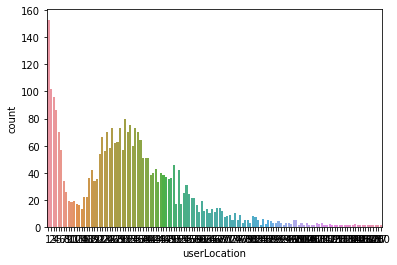

In [ ]:
sns.countplot(dados.groupby('publicationDate').userLocation.count());

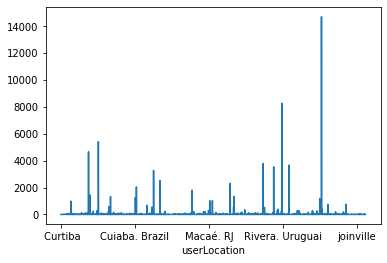

In [ ]:
dados.groupby('userLocation').averageRating.count().plot()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


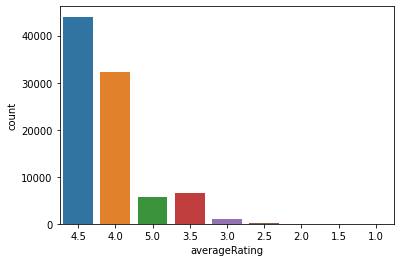

In [ ]:
sns.countplot(dados.averageRating);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


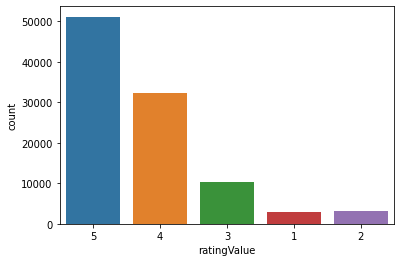

In [ ]:
sns.countplot(dados.ratingValue);

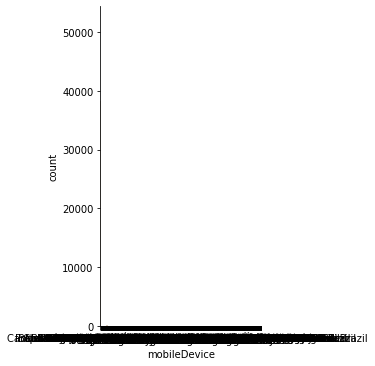

In [ ]:
sns.catplot(x="mobileDevice", kind="count", palette="ch:.25", data=dados)

### 4. Analise dos Sentimentos 

In [ ]:
def translateByTextBlob():
  dic2 = pd.DataFrame(dados)
  dic2['reviewBody']
  count = 0
  for _x in dic2['reviewBody']:
      count = count + 1  
      print(type(_x))
      x = _x.encode('utf-16', 'surrogatepass').decode('utf-16')
      print(x)
      
      print(count) #vai imprimir todos os reviews= 
          
      comentario_blob = TextBlob(x)
      print(type(comentario_blob))
      comentario_blob_us = comentario_blob.translate(to='us')

      for sentence_br, sentence in zip(comentario_blob.sentences, comentario_blob_us.sentences):
          print(sentence_br, ':', sentence.sentiment.subjectivity)
      if count == 5:
          print('**End**')
          break  

In [ ]:
translateByTextBlob()

NameError: ignored